In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import numpy as np
import json
from PIL import Image
from collections import Counter
from pathlib import Path
import gc

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as patches

from glob import glob

In [3]:
from time import time
from keras.models import load_model, Model, Sequential
from keras.layers import Lambda

Using TensorFlow backend.


In [4]:
vg_dir = 'visual_genome/data'

In [5]:
def silly_report(fn, msg):
    s = time()
    print('waiting for {0}'.format(msg), end='\r')
    out = fn()
    print(' '*len('waiting for {0}'.format(msg)), end='\r')
    e = time()
    print('{0} in {1:0.2f}s'.format(msg, e-s))
    return out


In [6]:
base_url = 'https://cs.stanford.edu/people/rak248/'

images = None
rels_from_file = None

## read image data from files
def load_images():
    return {
        item['image_id']: {
            'width'  : item['width'],
            'height' : item['height'],
            'path'   : item['url'].replace(base_url, '{0}/')
        }
        for item in json.load(open('{0}/image_data.json'.format(vg_dir)))
    }

# read corpus from the file
def load_rels():
    return json.load(open('{0}/relationships.json'.format(vg_dir)))

# retrieve pre-processed image ids
def load_image_ids():
    return list(np.load('{0}/relationships/image_ids.npy'.format(vg_dir)))

# preprocess the relations into triplets and bbox
def preprocess_rels():
    # name/names correction for reading content of nodes in the dataset
    def name_extract(x):
        if 'names' in x and len(x['names']):
            name = x['names'][0]
        elif 'name' in x:
            name = x['name']
        else:
            name = ''
        return name.strip().lower()

    # convert it into a set of (image, subject, predicate, object)
    triplets_key_values = {
        (
            rels_in_image['image_id'],
            name_extract(rel['subject']),
            rel['predicate'].lower().strip(),
            name_extract(rel['object']),
        ): (
            rels_in_image['image_id'],
            (name_extract(rel['subject']), rel['subject']['object_id'], (rel['subject']['x'],rel['subject']['y'],rel['subject']['w'],rel['subject']['h'])),
            rel['predicate'].lower().strip(),
            (name_extract(rel['object']), rel['object']['object_id'], (rel['object']['x'], rel['object']['y'], rel['object']['w'], rel['object']['h'])),
        )
        for rels_in_image in rels_from_file
        for rel in rels_in_image['relationships']
    }
    triplets = list(triplets_key_values.values())
    del triplets_key_values
    
    return triplets

def load_img_vf():
    #unseen_img_ids = list(np.load('visual_genome/data/relationships/image_ids_test.npy'))
    train_img_ids = {
        img_id
        for img_id,_,_,_ in triplets[:int(0.95*len(triplets))]
    }
    valid_img_ids = {
        img_id
        for img_id,_,_,_ in triplets[int(0.95*len(triplets)):]
    }
    unseen_img_ids = valid_img_ids - train_img_ids
    
    chunck_size = 10000
    img_visual_features = []
    for l in range(0, len(image_ids), chunck_size):
        vfs = np.load('{0}/relationships/image_resnet50_features_[{1}].npy'.format(vg_dir, l), allow_pickle=True)
        img_visual_features += [
            (iid, vf)
            for iid, vf in zip(image_ids[l:l+chunck_size], vfs)
            if iid in unseen_img_ids
            if type(vf) != int
        ]
        del vfs

    return dict(img_visual_features)

def load_obj_vf():
    object_ids = list(np.load('{0}/relationships/object_ids.npy'.format(vg_dir)))
    filtered_obj_ids = set([
        obj_id
        for item in triplets
        for obj_id in [item[1][1], item[3][1]]
    ])
    
    chunck_size = 100000
    visual_features = []
    for l in range(0, len(object_ids), chunck_size):
        vfs = np.load('{0}/relationships/objects_resnet50_features_[{1}].npy'.format(vg_dir, l), allow_pickle=True)
        visual_features += [
            (iid, vf)
            for iid, vf in zip(object_ids[l:l+chunck_size], vfs)
            if iid in filtered_obj_ids
            if type(vf) != int
        ]
    return dict(visual_features)

def filter_rels1():
    # clean the data from examples in which there is no saved vector for them
    return [
        item
        for item in triplets
        if item[0] in img_visual_features 
        if type(img_visual_features[item[0]]) != int
    ]

def filter_rels2():
    # clean the data from examples in which there is no saved vector for them
    return [
        item
        for item in triplets
        if item[0] in img_visual_features 
        if type(img_visual_features[item[0]]) != int
        if item[1][1] in visual_features 
        if type(visual_features[item[1][1]]) != int
        if item[3][1] in visual_features 
        if type(visual_features[item[3][1]]) != int
    ]
    

# run them in this order with silly report about time consumption:
images = silly_report(load_images, 'loading image names')
rels_from_file = silly_report(load_rels, 'loading relationships corpus')
image_ids = silly_report(load_image_ids, 'loading pre-processed image ids')
triplets = silly_report(preprocess_rels, 'preprocess rels into triplets+bbox')
img_visual_features = silly_report(load_img_vf, 'loading image visual features')
triplets = silly_report(filter_rels1, 'filtering relations')
visual_features = silly_report(load_obj_vf, 'loading bbox visual features')
triplets = silly_report(filter_rels2, 'filtering relations')

gc.collect()

#vocab = Counter([w.strip() for _,(sbj,_,_),pred,(obj,_,_) in triplets for w in ' '.join([sbj,pred,obj]).split(' ')])
#np.save('visual_genome/data/relationships/vocab_caption.npy', vocab)
vocab = np.load('{0}/relationships/vocab_caption.npy'.format(vg_dir), allow_pickle=True)[None][0]

word2ix = {w:i for i,w in enumerate(['<0>', '<s>']+list(vocab))}
ix2word = {i:w for w,i in word2ix.items()}
word2onehot = lambda w: np.array([0.]*word2ix[w] + [1.] + [0.]*(len(word2ix)-word2ix[w]-1))

#max_len = max(len(' '.join([sbj,pred,obj]).split(' ')) for _,(sbj,_,_),pred,(obj,_,_) in triplets)
max_len = 16 # if not filtering triplets with test-images this should be the result

loading image names in 0.37s   
loading relationships corpus in 32.24s  
loading pre-processed image ids in 0.01s   
preprocess rels into triplets+bbox in 10.80s  
loading image visual features in 379.31s 
filtering relations in 0.30s   
loading bbox visual features in 140.66s 
filtering relations in 0.20s   


In [7]:
def item2features(item):
    img_id,(sbj,object_id1,sbj_bbx),pred,(obj,object_id2,obj_bbx) = item

    # visual features
    vf0 = img_visual_features[img_id]
    vf1 = visual_features[object_id1]
    vf2 = visual_features[object_id2]

    # spatial features
    # based on VisKE
    a1 = sbj_bbx[2] * sbj_bbx[3]
    a2 = obj_bbx[2] * obj_bbx[3]
    if obj_bbx[0] <= sbj_bbx[0] <= obj_bbx[0]+obj_bbx[2] <= sbj_bbx[0] + sbj_bbx[2]:
        # overlap
        w = (obj_bbx[0]+obj_bbx[2]) - (sbj_bbx[0])
    elif obj_bbx[0] <= sbj_bbx[0] <= sbj_bbx[0] + sbj_bbx[2] <= obj_bbx[0]+obj_bbx[2]:
        # obj contains sbj
        w = sbj_bbx[2]
    elif sbj_bbx[0] <= obj_bbx[0] <= sbj_bbx[0] + sbj_bbx[2] <= obj_bbx[0]+obj_bbx[2]:
        # overlaps
        w = (sbj_bbx[0]+sbj_bbx[2]) - (obj_bbx[0])
    elif sbj_bbx[0] <= obj_bbx[0] <= obj_bbx[0]+obj_bbx[2] <= sbj_bbx[0] + sbj_bbx[2]:
        # subj contains obj
        w = obj_bbx[2]
    else:
        w = 0

    if obj_bbx[1] <= sbj_bbx[1] <= obj_bbx[1]+obj_bbx[3] <= sbj_bbx[1] + sbj_bbx[3]:
        # overlap
        h = (obj_bbx[1]+obj_bbx[3]) - (sbj_bbx[1])
    elif obj_bbx[1] <= sbj_bbx[1] <= sbj_bbx[1] + sbj_bbx[3] <= obj_bbx[1]+obj_bbx[3]:
        # obj contains sbj
        h = sbj_bbx[3]
    elif sbj_bbx[1] <= obj_bbx[1] <= sbj_bbx[1] + sbj_bbx[3] <= obj_bbx[1]+obj_bbx[3]:
        # overlaps
        h = (sbj_bbx[1]+sbj_bbx[3]) - (obj_bbx[1])
    elif sbj_bbx[1] <= obj_bbx[1] <= obj_bbx[1]+obj_bbx[3] <= sbj_bbx[1] + sbj_bbx[3]:
        # subj contains obj
        h = obj_bbx[3]
    else:
        h = 0

    overlap_a = w * h

    # dx; dy; ov; ov1; ov2; h1;w1; h2;w2; a1; a2
    sf1 = [
        #obj_bbx[0] - sbj_bbx[0], # dx = x2 - x1 
        #obj_bbx[1] - sbj_bbx[1], # dy = y2 - y1
        obj_bbx[0] - sbj_bbx[0] + (obj_bbx[2] - sbj_bbx[2])/2, # dx = x2 - x1 + (w2 - w1)/2
        obj_bbx[1] - sbj_bbx[1] + (obj_bbx[3] - sbj_bbx[3])/2, # dy = y2 - y1 + (h2 - h1)/2
        0 if (a1+a2) == 0 else overlap_a/(a1+a2), # ov
        0 if a1 == 0 else overlap_a/a1, # ov1
        0 if a2 == 0 else overlap_a/a2, # ov2
        sbj_bbx[3], # h1
        sbj_bbx[2], # w1
        obj_bbx[3], # h2
        obj_bbx[2], # w2
        a1, # a1
        a2, # a2
    ]
    
    # spatial template (two attention masks)
    x1, y1, w1, h1 = sbj_bbx
    x2, y2, w2, h2 = obj_bbx

    mask = np.zeros([7,7,2])
    mask[int(y1*7):int((y1+h1)*7), int(x1*7):int((x1+w1)*7), 0] = 1 # mask bbox 1 
    mask[int(y2*7):int((y2+h2)*7), int(x2*7):int((x2+w2)*7), 0] = 1 # mask bbox 2

    sf2 = mask.flatten()
    
    # sentence encoding
    sent = ' '.join([sbj,pred,obj]).split(' ')
    sent = [word2ix['<s>']]+[word2ix[w] for w in sent]+[word2ix['<0>']]*(1+max_len-len(sent))

    return vf0, sf1, sf2, vf1, vf2, sent

def generator_features_description(
        batch_size=32,
        split=(0.,1.),
        all_data = triplets,
        mode='bbox',
        spatial_order=None,
        shuffle=True,
    ):
    while True:
        gc.collect()
        
        _all_data = all_data[int(len(all_data)*split[0]):int(len(all_data)*split[1])]

        # shuffle 
        if shuffle:
            np.random.shuffle(_all_data)
        
        
        # start
        X_vfs = []
        X_sfs = []
        X_objs = []
        X_sents = []
        
        for item in _all_data:
            vf0, sf1, sf2, vf1, vf2, sent = item2features(item)
            
            X_vfs.append(vf0)
            X_sents.append(sent)
            
            if mode[:4] == 'bbox' or mode[-4:] == 'bbox':
                X_sfs.append(sf1)
            elif mode[:9] == 'attention':
                X_sfs.append(sf2)
            
            if mode[:4] == 'bbox' or mode[:9] == 'attention' or mode[:8] == 'implicit':
                l = [vf1, vf2]
                
                if mode[-2:] == '-r' and spatial_order is None:
                    np.random.shuffle(l)
                else:
                    l = [l[i] for i in spatial_order]
                    
                X_objs.append(l)

            if len(X_sents) == batch_size:
                sents = np.array(X_sents)
                if mode[:4] == 'bbox' or mode[:9] == 'attention':
                    yield ([np.array(X_vfs), np.array(X_sfs), np.array(X_objs), sents[:, :-1]], np.expand_dims(sents[:, 1:], 2))
                    
                elif mode[:8] == 'implicit':
                    yield ([np.array(X_vfs), np.array(X_objs), sents[:, :-1]], np.expand_dims(sents[:, 1:], 2))
                    
                elif mode == 'spatial_adaptive-bbox':
                    yield ([np.array(X_vfs), np.array(X_sfs), sents[:, :-1]], np.expand_dims(sents[:, 1:], 2))

                elif mode[:7] == 'no-beta' or mode == 'spatial_adaptive' or mode == 'spatial_adaptive-attention':
                    yield ([np.array(X_vfs), sents[:, :-1]], np.expand_dims(sents[:, 1:], 2))
                    
                X_vfs = []
                X_sfs = []
                X_objs = []
                X_sents = []
                


## Load the saved models

In [8]:
modes = [
    'no-beta',
    'implicit',
    'spatial_adaptive',
    'bbox',
    'attention',
    'spatial_adaptive-bbox',
    'spatial_adaptive-attention',
    'bbox-r',
    'attention-r',
    'implicit-r',
]

mode2title = {}
mode2title['no-beta'] = 'simple'
mode2title['implicit'] = 'td'
mode2title['attention'] = 'td + mask'
mode2title['bbox'] = 'td + VisKE'
mode2title['implicit-r'] = 'td (rand)'
mode2title['attention-r'] = 'td + mask (rand)'
mode2title['bbox-r'] = 'td + VisKE (rand)'
mode2title['spatial_adaptive'] = 'bu49'
mode2title['spatial_adaptive-bbox'] = 'bu49 + mask'
mode2title['spatial_adaptive-attention'] = 'bu49 + VisKE'

n_epochs = 15
batch_size = 128

In [9]:
# model file directory
dir_path = '{0}/relationships/'.format(vg_dir)
#dir_path = 'saved_models0'

# model file names
models = {
    mode: 'caption_model_{0}_{1}epochs.h5'.format(mode, n_epochs)
    for mode in modes
    if Path(dir_path + 'caption_model_{0}_{1}epochs.h5'.format(mode, n_epochs)).is_file() 
}

# how to load models from file names
def load_all_models():
    return {
        mode: load_model(dir_path + filename)
        for mode, filename in models.items()
    }
# this is how to load models
models = silly_report(load_all_models, 'loading all models')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
loading all models in 96.59s  


In [10]:
models

{'no-beta': <keras.engine.training.Model at 0x7f67c9fa7a58>,
 'implicit': <keras.engine.training.Model at 0x7f67ca0e3ac8>,
 'spatial_adaptive': <keras.engine.training.Model at 0x7f67ca7c3668>,
 'bbox': <keras.engine.training.Model at 0x7f67cae154a8>,
 'attention': <keras.engine.training.Model at 0x7f67cb596940>,
 'spatial_adaptive-bbox': <keras.engine.training.Model at 0x7f67cbdd0588>,
 'spatial_adaptive-attention': <keras.engine.training.Model at 0x7f67cc5006d8>,
 'bbox-r': <keras.engine.training.Model at 0x7f67ccc4e470>,
 'attention-r': <keras.engine.training.Model at 0x7f67cd3d0278>,
 'implicit-r': <keras.engine.training.Model at 0x7f63907c0128>}

## Load the spatial relations dictionary 

In [14]:
# dictionary of spatial relations from two books.
composit_simple = np.load('composit2simple.npy')
composit_simple = composit_simple.T
simple_classes_set = list(set(composit_simple[:,1]))
simple_classes = {
    composit: simple_classes_set.index(simple)
    for composit,simple in composit_simple
}

simple2composit = {
    rel: [composit for composit,simple in composit_simple if rel == simple]
    for rel in simple_classes_set
}

composit2simple = {
    composit: simple
    for composit,simple in composit_simple
}

# the simple form of spatial relations in this evaluation dataset
rels = Counter(composit2simple[rel] for _,_,rel,_ in triplets if rel in composit2simple)

#### Create buckets of examples with fixed size of samples

In [15]:
# make buckets of evaluation for each spatial relation
bucket_size = 40
buckets = dict()
for rel in rels:
    _triplets = [item for item in triplets if item[2] in composit2simple and composit2simple[item[2]] == rel]
    if len(_triplets) > 40:
        np.random.shuffle(_triplets)
        buckets[rel] = _triplets[:bucket_size]


## Validation Loss 
Run this part if you want to reproduce the results

#### Save the results?

## The attention models

In [11]:
att_archs = {
    'bbox',
    'attention',
    'implicit',
    'bbox-r',
    'attention-r',
    'implicit-r',
}

att_models = dict()
for mode, model in models.items():
    if mode not in att_archs:
        continue
    inputs = model.inputs
    att_models[mode] = Model(inputs, model.layers[-2].input)


In [12]:
# this creates the test data for predict method
def generator_wraper(generator):
    for o1, o2 in generator:
        yield o1


In [13]:
# L1-normalisation (considering that all values are positive)
def normalize(x):
    return x / np.expand_dims(x.sum(-1), -1)

### Attention probes
Run this only for re-prodicing the attentions

In [27]:
triplet_att_results = {}
# for each attention results (based samples in each bucket of relation)
for rel in att_results:
    if rel is None:
        _triplets = triplets[:-(len(triplets)%batch_size)]
    else:
        _triplets = buckets[rel]
    
    triplet_att_results[rel] = dict()
    for mode in att_results[rel]:
        triplet_att_results[rel][mode] = dict()
        for so in att_results[rel][mode]:
            triplet_att_results[rel][mode][so] = []
            
            # the attentions
            norms, alpha, sents = att_results[rel][mode][so]
            
            # find the image, and the bounding boxes associated with each sample
            for i, (img_id, (_trg,_,bbox1), _rel, (_lnd,_,bbox2)) in enumerate(_triplets):
                # figuer out the path
                #filename = images[img_id]['path']
                
                # normalisation!
                a = norms[i] * alpha[i]
                a = a / np.expand_dims(a.sum(-1), -1)

                pos_start = 0
                a_trg = [
                    np.mean(a[pos_start:pos_start+len(_trg.split(' ')), j], 0)
                    for j in range(a.shape[1])
                ]
                
                pos_start += len(_trg.split(' '))
                a_rel = [
                    np.mean(a[pos_start:pos_start+len(_rel.split(' ')), j], 0)
                    for j in range(a.shape[1])
                ]
                
                pos_start += len(_rel.split(' '))
                a_lnd = [
                    np.mean(a[pos_start:pos_start+len(_lnd.split(' ')), j], 0)
                    for j in range(a.shape[1])
                ]
                
                triplet_att_results[rel][mode][so].append([a_trg, a_rel, a_lnd])

#### Save attentions and the inputs to these attentions

In [233]:
trg, rel, lnd, _rel

('trees', 'on side of', 'slope', 'side')

In [253]:
fig.clf()
ax.cla()
plt.close('all')
gc.collect()

90

In [236]:
(att_results[_rel]['bbox'][(0,1)][0] * att_results[_rel]['bbox'][(0,1)][1]).shape

(40, 17, 4)

In [246]:
%reset out

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Flushing output cache (3 entries)


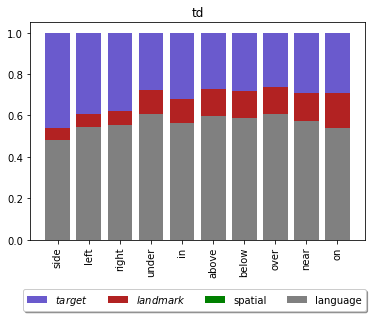

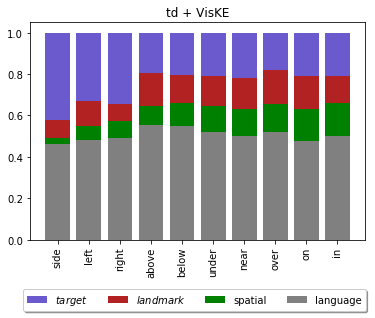

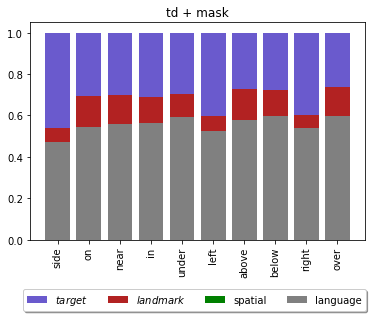

In [828]:
rel_att_results = dict()
for rel, atts in att_results.items():
    if rel is None:
        continue

    rel_att_results[rel] = dict()
    for i, mode in enumerate(atts):
        for so in atts[mode]:
            if (mode,so) not in mode2plotorder:
                continue
            
            alphas, _, sents = atts[mode][so]

            alphas_ = []
            for alpha, sent in zip(alphas, sents):
                sents_mask = np.expand_dims(np.array(sent == word2ix[rel], dtype=np.float), 1)
                alphas_.append((alpha * sents_mask).sum(0))
                            
            a = np.array(alphas_)
            
            #a_min = a.min(0)
            #a_max = a.max(0)
            
            # normalize the average attentions:
            #a = (a - a_min) / (a_max - a_min)
            a = a / np.expand_dims(a.sum(-1), -1)

            a = a.mean(0)
            rel_att_results[rel][mode] = a

    

for (mode,so) in mode2plotorder:
    
    limited_rels = ['right', 'left', 'above', 'over', 'under', 'below', 'on', 'in', 'near', 'side']
    rels_a = sorted([
        (rel, rel_att_results[rel][mode])
        for rel in rel_att_results
        if rel in limited_rels
    ], key=lambda x: x[1][1])
    
    labels, a = list(zip(*rels_a))
    a = np.array(a)

    plt.title(mode2title[mode])
    if a.shape[-1] == 4:
        line_v2 = plt.bar(range(len(labels)), np.sum(a[:, :4], -1), label='$v_2$', color='slateblue')
        line_v1 = plt.bar(range(len(labels)), np.sum(a[:, :3], -1), label='$v_1$', color='firebrick')
        line_sp = plt.bar(range(len(labels)), np.sum(a[:, :2], -1), label='sp', color='green')
        line_lm = plt.bar(range(len(labels)), np.sum(a[:, :1], -1), label='lm', color='gray')
    else:
        line_v2 = plt.bar(range(len(labels)), np.sum(a[:, :3], -1), label='$v_2$', color='slateblue')
        line_v1 = plt.bar(range(len(labels)), np.sum(a[:, :2], -1), label='$v_1$', color='firebrick')
        line_lm = plt.bar(range(len(labels)), np.sum(a[:, :1], -1), label='lm', color='gray')
    
    plt.xticks(range(len(labels)), labels, rotation=90)
    # Put a legend below current axis
    plt.legend(
        handles=(line_v2, line_v1, line_sp, line_lm),
        labels=('$target$', '$landmark$', 'spatial', 'language'),
        loc='lower center',
        bbox_to_anchor=(0.49, -0.35),
        fancybox=True, shadow=True, ncol=5)
    plt.show()

In [829]:
# model file names
new_models = {
    'bbox-r': 'x_caption_model_bbox-r_6epochs.h5',
    'implicit-r': 'x_caption_model_implicit-r_7epochs.h5',
    'attention-r': 'x_caption_model_attention-r_11epochs.h5',
}

# this is how to load models
new_models = {
    mode: load_model(dir_path + filename)
    for mode, filename in new_models.items()
}

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [830]:
new_models

{'bbox-r': <keras.engine.training.Model at 0x7f74aa73d860>,
 'implicit-r': <keras.engine.training.Model at 0x7f751e5382e8>,
 'attention-r': <keras.engine.training.Model at 0x7f750547d390>}

In [831]:
new_results = dict()

# the overall results are stored under 'None' index 
new_results[None] = dict()
for mode, model in new_models.items():
    new_results[None][mode] = dict()
    for so in [(0,1)]:
        out = model.evaluate_generator(
            generator_features_description(
                batch_size=batch_size,
                split=(0,1.),
                mode=mode, 
                spatial_order=so,
                shuffle=False,
                ),
            steps=int(len(triplets)/batch_size)
        )
        new_results[None][mode] = out
        print('{0:18} : {1:0.4f}'.format(mode2title[mode], out))

# report the results for each bucket
for rel, _triplets in buckets.items():
    print('====== {} ======'.format(rel))
    new_results[rel] = dict()
    for mode, model in new_models.items():
        new_results[rel][mode] = dict()
        if mode in ['bbox', 'implicit', 'attention', 'bbox-r', 'implicit-r', 'attention-r']:
            spatial_orders = [(0,1), (1,0)]
        else: 
            spatial_orders = [None]
        
        for spatial_order in spatial_orders:
            out = model.evaluate_generator(
                generator_features_description(
                    batch_size=bucket_size,
                    split=(0,1.),
                    mode=mode,
                    all_data=_triplets,
                    spatial_order=spatial_order,
                ),
                steps=int(len(_triplets)/bucket_size),
            )
            new_results[rel][mode][spatial_order] = out
            print('{0:18} ({2}): {1:0.4f}'.format(
                mode if mode not in mode2title else mode2title[mode],
                out,
                'lnd-trg' if spatial_order == (1,0) else 'trg-lnd'
            ))


td + VisKE (rand)  : 0.9678
td (rand)          : 0.9654
td + mask (rand)   : 0.9116
====== on ======
td + VisKE (rand)  (trg-lnd): 0.8312
td + VisKE (rand)  (lnd-trg): 0.8312
td (rand)          (trg-lnd): 0.8311
td (rand)          (lnd-trg): 0.8311
td + mask (rand)   (trg-lnd): 0.7771
td + mask (rand)   (lnd-trg): 0.7776
====== side ======
td + VisKE (rand)  (trg-lnd): 1.0318
td + VisKE (rand)  (lnd-trg): 1.0318
td (rand)          (trg-lnd): 1.0058
td (rand)          (lnd-trg): 1.0058
td + mask (rand)   (trg-lnd): 0.9451
td + mask (rand)   (lnd-trg): 0.9436
====== in ======
td + VisKE (rand)  (trg-lnd): 0.8363
td + VisKE (rand)  (lnd-trg): 0.8363
td (rand)          (trg-lnd): 0.8565
td (rand)          (lnd-trg): 0.8565
td + mask (rand)   (trg-lnd): 0.8037
td + mask (rand)   (lnd-trg): 0.8031
====== with ======
td + VisKE (rand)  (trg-lnd): 1.0008
td + VisKE (rand)  (lnd-trg): 1.0008
td (rand)          (trg-lnd): 0.9963
td (rand)          (lnd-trg): 0.9963
td + mask (rand)   (trg-lnd): 

In [832]:
new_att_models = dict()
for mode, model in new_models.items():
    if mode not in att_archs:
        continue
    inputs = model.inputs
    new_att_models[mode] = Model(inputs, model.layers[-2].input)


In [838]:
new_att_results = dict()

for rel, _triplets in buckets.items():
    print('====== {} ======'.format(rel))
    
    new_att_results[rel] = dict()
    for mode, model in new_att_models.items():
        new_att_results[rel][mode] = dict()
        if mode in ['bbox', 'implicit', 'attention', 'bbox-r', 'implicit-r', 'attention-r']:
            spatial_orders = [(0,1), (1,0)]
        else: 
            spatial_orders = [None]
        
        for so in spatial_orders:
            out = model.predict_generator(
                generator_wraper(generator_features_description(
                    batch_size=bucket_size, 
                    split=(0,1.), 
                    mode=mode, 
                    all_data=_triplets,
                    spatial_order=so,
                    shuffle=False,
                )),
                steps=int(len(_triplets)/bucket_size),
            )
            
            sents = np.array([item2features(item)[-1][1:] for item in _triplets])
            sents_mask = np.expand_dims(np.array(sents != 0, dtype=np.float), 2)

            if len(out) == 4:
                lm, sp, vs, alpha = out
                lm_norms = np.expand_dims(np.linalg.norm(lm, axis=-1), 2)
                vs_norm = np.repeat(np.expand_dims(np.linalg.norm(vs, axis=-1), 1), lm.shape[1], axis=1)
                sp_norm = np.repeat(np.expand_dims(np.expand_dims(np.linalg.norm(sp, axis=-1), 1), 1), lm.shape[1], axis=1)
                norms = np.concatenate([lm_norms, sp_norm, vs_norm, ], axis=2)
                new_att_results[rel][mode][so] = [norms * alpha, alpha, sents]
            else:
                lm, vs, alpha = out
                lm_norms = np.expand_dims(np.linalg.norm(lm, axis=-1), 2)
                vs_norm = np.repeat(np.expand_dims(np.linalg.norm(vs, axis=-1), 1), lm.shape[1], axis=1)
                norms = np.concatenate([lm_norms, vs_norm], axis=2)
                new_att_results[rel][mode][so] = [norms * alpha, alpha, sents]
                
            print('{0:18} ({2}): {1}'.format(
                mode if mode not in mode2title else mode2title[mode],
                ' '.join(['{0:0.4f}'.format(f) for f in att_results[rel][mode][so][1].mean(0).mean(0)]),
                'lnd-trg' if so == (1,0) else 'trg-lnd'
            ))

            

====== on ======
td + VisKE (rand)  (trg-lnd): 1.0000 0.0000 0.0000 0.0000
td + VisKE (rand)  (lnd-trg): 1.0000 0.0000 0.0000 0.0000
td (rand)          (trg-lnd): 0.9470 0.0223 0.0306
td (rand)          (lnd-trg): 0.9475 0.0303 0.0221
td + mask (rand)   (trg-lnd): 0.9538 0.0462 0.0000 0.0000
td + mask (rand)   (lnd-trg): 0.9540 0.0460 0.0000 0.0000
====== side ======
td + VisKE (rand)  (trg-lnd): 1.0000 0.0000 0.0000 0.0000
td + VisKE (rand)  (lnd-trg): 1.0000 0.0000 0.0000 0.0000
td (rand)          (trg-lnd): 0.9430 0.0227 0.0343
td (rand)          (lnd-trg): 0.9441 0.0334 0.0225
td + mask (rand)   (trg-lnd): 0.9566 0.0434 0.0000 0.0000
td + mask (rand)   (lnd-trg): 0.9569 0.0431 0.0000 0.0000
====== in ======
td + VisKE (rand)  (trg-lnd): 1.0000 0.0000 0.0000 0.0000
td + VisKE (rand)  (lnd-trg): 1.0000 0.0000 0.0000 0.0000
td (rand)          (trg-lnd): 0.9493 0.0233 0.0274
td (rand)          (lnd-trg): 0.9502 0.0269 0.0230
td + mask (rand)   (trg-lnd): 0.9675 0.0325 0.0000 0.0000
td 

KeyboardInterrupt: 

In [839]:
gc.collect()

274

In [870]:
a_, a, s = att_results['on']['bbox-r'][(0,1)]

In [874]:
a_

array([[[8.7291706e-01, 3.1413612e-09, 0.0000000e+00, 0.0000000e+00],
        [3.0665045e+00, 3.3373482e-09, 0.0000000e+00, 0.0000000e+00],
        [1.5884610e+00, 3.0190248e-09, 0.0000000e+00, 0.0000000e+00],
        ...,
        [3.2712572e+00, 3.2284311e-09, 0.0000000e+00, 0.0000000e+00],
        [3.2732003e+00, 3.2285294e-09, 0.0000000e+00, 0.0000000e+00],
        [3.2749550e+00, 3.2286032e-09, 0.0000000e+00, 0.0000000e+00]],

       [[8.2214403e-01, 3.1229943e-09, 0.0000000e+00, 0.0000000e+00],
        [1.8879023e+00, 3.0875644e-09, 0.0000000e+00, 0.0000000e+00],
        [1.5475278e+00, 3.1787826e-09, 0.0000000e+00, 0.0000000e+00],
        ...,
        [3.3112054e+00, 3.2037690e-09, 0.0000000e+00, 0.0000000e+00],
        [3.3116608e+00, 3.2037444e-09, 0.0000000e+00, 0.0000000e+00],
        [3.3119342e+00, 3.2037200e-09, 0.0000000e+00, 0.0000000e+00]],

       [[7.4736249e-01, 3.1308458e-09, 0.0000000e+00, 0.0000000e+00],
        [1.7919238e+00, 3.0555443e-09, 0.0000000e+00, 0.0000